In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./dataset/dataset/transfers.csv')
dataset = df[df['dir'] == 'in']
dataset

,league,season,window,team_id,team_name,team_country,dir,player_id,player_name,player_age,...,counter_team_id,counter_team_name,counter_team_country,transfer_fee_amnt,market_val_amnt,is_free,is_loan,is_loan_end,is_retired,transfer_id
0,GB1,2009,s,985,Manchester United,England,in,33544,Antonio Valencia,23.0,...,1071,Wigan Athletic,England,18800000.0,NaN,False,False,False,False,310832
1,GB1,2009,s,985,Manchester United,England,in,62049,Mame Diouf,21.0,...,687,Molde FK,Norway,4500000.0,1600000.0,False,False,False,False,319841
2,GB1,2009,s,985,Manchester United,England,in,43261,Gabriel Obertan,20.0,...,40,FC Girondins Bordeaux,France,4000000.0,400000.0,False,False,False,False,315185
3,GB1,2009,s,985,Manchester United,England,in,1397,Michael Owen,29.0,...,762,Newcastle United,England,0.0,NaN,True,False,False,False,306421
4,GB1,2009,s,985,Manchester United,England,in,73538,Scott Moffatt,18.0,...,5242,Manchester United U18,England,NaN,NaN,False,False,False,False,339015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70000,NL1,2021,w,385,Fortuna Sittard,Netherlands,in,140032,Andreas Samaris,32.0,...,515,Without Club,Without Club,NaN,1500000.0,False,False,False,False,3633188
70001,NL1,2021,w,306,SC Heerenveen,Netherlands,in,257808,Runar Espejord,25.0,...,1293,Tromsø IL,Norway,NaN,500000.0,False,True,True,False,3071862
70002,NL1,2021,w,306,SC Heerenveen,Netherlands,in,580142,Joaquín Fernández,22.0,...,37535,Montevideo City Torque,Uruguay,NaN,100000.0,False,True,True,False,3268245
70003,NL1,2021,w,468,Sparta Rotterdam,Netherlands,in,340353,Maduka Okoye,22.0,...,1010,Watford FC,England,NaN,1000000.0,False,True,False,False,3619917


In [3]:
# rimuovi i 6 player che non hanno età
dataset.dropna(subset=['player_age'], inplace=True)
# sostituisci i valori di trasferimento Nan con 0
dataset['transfer_fee_amnt'].fillna(0, inplace=True)
# sostituisci i valori di valore di mercato Nan con 0
dataset['market_val_amnt'].fillna(0, inplace=True)
# rimuovi i trasferimenti senza squadra di destinazione (ovvero svincoli)
dataset = dataset[dataset['counter_team_name'] != 'Without Club'] 
# rimuovi i trasferimenti senza squadra di provenienza (ovvero ingaggio di svincolati)
dataset = dataset[dataset['team_name'] != 'Without Club']
# Rimuovi le righe in cui 'team_id' o 'counter_team_id' sono uguali a 'Retired'
dataset = dataset[(dataset['team_id'] != 'Retired') & (dataset['counter_team_id'] != 'Retired')]
# Rimozione dei rientri dal prestito (is_loan_end = True)
dataset = dataset[dataset['is_loan_end'] == False]

# Conversione dei valori di 'team_id' e 'counter_team_id' in interi
dataset['team_id'] = dataset['team_id'].astype(int)
dataset['counter_team_id'] = dataset['counter_team_id'].astype(int)


print('Il dataset è composto da ', dataset.shape[0], ' trasferimenti')

Il dataset è composto da  22696  trasferimenti


/var/folders/61/9rphml817c1d45n8g26p1ltm0000gn/T/ipykernel_1319/3190214965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.dropna(subset=['player_age'], inplace=True)
/var/folders/61/9rphml817c1d45n8g26p1ltm0000gn/T/ipykernel_1319/3190214965.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['transfer_fee_amnt'].fillna(0, inplace=True)
/var/folders/61/9rphml817c1d45n8g26p1ltm0000gn/T/ipykernel_1319/3190214965.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [52]:
G = nx.MultiDiGraph()

for index, row in dataset.iterrows():
    player_name = row['player_name']
    
    # Utilizza l'ID della squadra come identificatore del nodo
    team1 = row['team_id']
    team2 = row['counter_team_id']
    
    if not G.has_node(team1):
        G.add_node(team1, label='team', name=row['team_name'], country=row['team_country'])
    if not G.has_node(team2):
        G.add_node(team2, label='team', name=row['counter_team_name'], country=row['counter_team_country'])
    
    transfer_attributes = {
        'transfer_id': row['transfer_id'],
        'player_id': row['player_id'],
        'player_name': row['player_name'],
        'player_age': row['player_age'],
        'season': row['season'],
        'window': row['window'],
        'transfer_fee_amnt': row['transfer_fee_amnt'],
        'is_loan': row['is_loan'],
        'market_val_amnt': row['market_val_amnt']
    }
    
    G.add_edge(team2, team1, label='transfer', **transfer_attributes) 

print('Numero di nodi:', G.number_of_nodes())
print('Numero di archi:', G.number_of_edges())


Numero di nodi: 2193
Numero di archi: 22696


In [5]:
# Calcola il grado dei nodi in ingresso e in uscita
in_degree = G.in_degree()
out_degree = G.out_degree()

# Crea un elenco dei nodi (team) che soddisfano il criterio di avere almeno un arco in ingresso e uno in uscita 
selected_teams = [node for node in G.nodes() if out_degree[node] > 0 and in_degree[node] > 0 ] 

print('Nodi selezionati -> ', len(selected_teams), ' nodi con almeno 10 operazioni di mercato')

# Crea un nuovo grafo (sottografo) basato sui nodi selezionati
net = G.subgraph(selected_teams)

net = net.copy()

# Identifica i nodi che soddisfano il criterio (transfer_fee_amnt uguale a 0 per tutti gli archi uscenti e entranti)
nodes_to_remove = []
for node in net.nodes():
    out_edges = net.out_edges(node, data=True)
    in_edges = net.in_edges(node, data=True)
        
    if all(attr['transfer_fee_amnt'] == 0 for _, _, attr in out_edges) and all(attr['transfer_fee_amnt'] == 0 for _, _, attr in in_edges):
        nodes_to_remove.append(node)

print('Nodi da rimuovere -> ', len(nodes_to_remove), ' nodi con tutte le operazioni di mercato a 0')

net.remove_nodes_from(nodes_to_remove)

print('Nodi -> ', net.number_of_nodes())
print('Archi -> ', net.number_of_edges())
print('Density -> ', nx.density(net))

Nodi selezionati ->  239  nodi con almeno 10 operazioni di mercato
Nodi da rimuovere ->  3  nodi con tutte le operazioni di mercato a 0
Nodi ->  236
Archi ->  11648
Density ->  0.21002524341868012


/Users/manuelplacella/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/manuelplacella/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/manuelplacella/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/manuelplacella/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

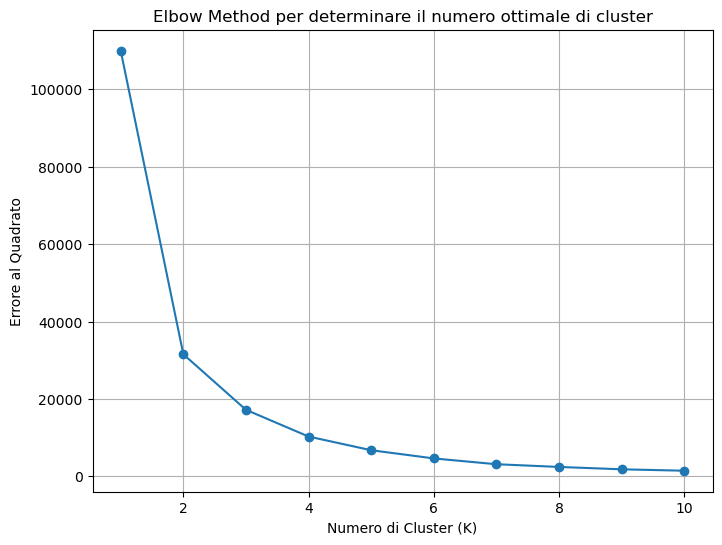

In [53]:
###### CALCOLO DEL K MIGLIORE ######

from sklearn.cluster import KMeans
import numpy as np

# Ottieni il grafo dei nodi
degrees = dict(net.degree())

# Estrai i gradi in una lista per usarli nel K-Means
degree_values = list(degrees.values())

# Inizializza una lista vuota per memorizzare l'errore al quadrato
inertia = []

# Esegui K-Means per un intervallo di valori di K
for k in range(1, 11):  # Prova da 1 a 10 cluster
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(np.array(degree_values).reshape(-1, 1))
    inertia.append(kmeans.inertia_)

# Disegna il grafico dell'errore al quadrato in funzione di K
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Numero di Cluster (K)')
plt.ylabel('Errore al Quadrato')
plt.title('Elbow Method per determinare il numero ottimale di cluster')
plt.grid()
plt.show()

/Users/manuelplacella/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


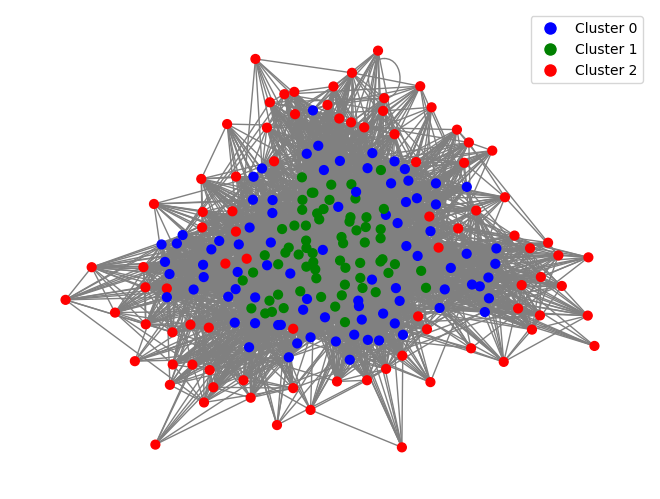

In [54]:

# Ottieni il grafo dei nodi 
degrees = dict(net.degree())

# Estrai i gradi in una lista per usarli nel kmeans
degree_values = list(degrees.values())

# Esegui il kmeans con 3 cluster
kmeans = KMeans(n_clusters=3)

# Addestra il modello utilizzando la lista di gradi
kmeans.fit(np.array(degree_values).reshape(-1, 1))

# Ottieni le etichette dei cluster per ogni nodo
cluster_labels = kmeans.labels_

# Aggiungi le etichette dei cluster come attributo ai nodi
for node, label in zip(net.nodes(), cluster_labels):
    net.nodes[node]['cluster'] = label

#################  Rappresentazione del grafo  #################

# Definisci una lista di colori per i cluster
cluster_colors = ['b', 'g', 'r']

# Crea un dizionario che mappa i cluster alle rispettive etichette dei colori
cluster_color_mapping = {cluster: color for cluster, color in enumerate(cluster_colors)}

# Estrai gli attributi dei cluster dai nodi
cluster_labels = nx.get_node_attributes(net, 'cluster')

# Crea una lista di colori per ogni nodo basata sui cluster
node_colors = [cluster_color_mapping[cluster_labels[node]] for node in net.nodes()]

# Disegna il grafo utilizzando i colori dei nodi
pos = nx.spring_layout(net)  # Puoi utilizzare un layout diverso se preferisci
nx.draw(net, pos, node_color=node_colors, with_labels=False, node_size=40, edge_color='grey')

# Aggiungi una legenda ai colori dei cluster
legend_labels = [f'Cluster {cluster}' for cluster in range(len(cluster_colors))]
legend_colors = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in zip(legend_labels, cluster_colors)]
plt.legend(handles=legend_colors)

# Mostra il grafico
plt.show()

In [57]:
# Definisci il numero del cluster da cui desideri ottenere i nodi
cluster_to_print = 0

# Estrai gli attributi dei cluster dai nodi
cluster_labels = nx.get_node_attributes(net, 'cluster')

# Inizializza variabili per calcolare il numero totale di trasferimenti e il numero di nodi nel cluster
total_transfers = 0
num_nodes_in_cluster = 0

# Itera attraverso i nodi nel cluster desiderato e stampa l'ID, il nome e il numero di trasferimenti
for node in net.nodes():
    if cluster_labels[node] == cluster_to_print:
        num_nodes_in_cluster += 1
        total_transfers += net.degree(node)
        node_id = node
        node_name = net.nodes[node]['name']
        num_transfers = net.degree(node)
        print(f'ID: {node_id}, Nome: {node_name}, Numero di Trasferimenti: {num_transfers}')

# Calcola il numero medio di trasferimenti
average_transfers = total_transfers / num_nodes_in_cluster

# Stampa il numero medio di trasferimenti
print(f'\nNumero Medio di Trasferimenti nel Cluster: {average_transfers}')


ID: 512, Nome: Stoke City, Numero di Trasferimenti: 55
ID: 1025, Nome: Bologna FC 1909, Numero di Trasferimenti: 52
ID: 3, Nome: 1. FC Köln, Numero di Trasferimenti: 56
ID: 1039, Nome: Queens Park Rangers, Numero di Trasferimenti: 39
ID: 16, Nome: Borussia Dortmund, Numero di Trasferimenti: 55
ID: 18, Nome: Borussia Mönchengladbach, Numero di Trasferimenti: 48
ID: 15, Nome: Bayer 04 Leverkusen, Numero di Trasferimenti: 54
ID: 27, Nome: Bayern Munich, Numero di Trasferimenti: 53
ID: 543, Nome: Wolverhampton Wanderers, Numero di Trasferimenti: 53
ID: 42, Nome: Hannover 96, Numero di Trasferimenti: 45
ID: 44, Nome: Hertha BSC, Numero di Trasferimenti: 57
ID: 1071, Nome: Wigan Athletic, Numero di Trasferimenti: 37
ID: 60, Nome: SC Freiburg, Numero di Trasferimenti: 41
ID: 1085, Nome: Vitória Setúbal FC, Numero di Trasferimenti: 38
ID: 1090, Nome: AZ Alkmaar, Numero di Trasferimenti: 52
ID: 1095, Nome: ESTAC Troyes, Numero di Trasferimenti: 33
ID: 595, Nome: SC Bastia, Numero di Trasferimen

In [48]:
# Definisci il numero del cluster da cui desideri ottenere i nodi
cluster_to_print = 1

# Estrai gli attributi dei cluster dai nodi
cluster_labels = nx.get_node_attributes(net, 'cluster')

# Inizializza variabili per calcolare il numero totale di trasferimenti e il numero di nodi nel cluster
total_transfers = 0
num_nodes_in_cluster = 0

# Itera attraverso i nodi nel cluster desiderato e stampa l'ID, il nome e il numero di trasferimenti
for node in net.nodes():
    if cluster_labels[node] == cluster_to_print:
        num_nodes_in_cluster += 1
        total_transfers += net.degree(node)
        node_id = node
        node_name = net.nodes[node]['name']
        num_transfers = net.degree(node)
        print(f'ID: {node_id}, Nome: {node_name}, Numero di Trasferimenti: {num_transfers}')

# Calcola il numero medio di trasferimenti
average_transfers = total_transfers / num_nodes_in_cluster

# Stampa il numero medio di trasferimenti
print(f'\nNumero Medio di Trasferimenti nel Cluster: {average_transfers}')


ID: 5, Nome: AC Milan, Numero di Trasferimenti: 83
ID: 11, Nome: Arsenal FC, Numero di Trasferimenti: 83
ID: 12, Nome: AS Roma, Numero di Trasferimenti: 86
ID: 13, Nome: Atlético de Madrid, Numero di Trasferimenti: 79
ID: 1038, Nome: UC Sampdoria, Numero di Trasferimenti: 67
ID: 1041, Nome: Olympique Lyon, Numero di Trasferimenti: 74
ID: 24, Nome: Eintracht Frankfurt, Numero di Trasferimenti: 61
ID: 1049, Nome: Valencia CF, Numero di Trasferimenti: 80
ID: 1050, Nome: Villarreal CF, Numero di Trasferimenti: 66
ID: 29, Nome: Everton FC, Numero di Trasferimenti: 61
ID: 31, Nome: Liverpool FC, Numero di Trasferimenti: 77
ID: 33, Nome: FC Schalke 04, Numero di Trasferimenti: 70
ID: 39, Nome: 1.FSV Mainz 05, Numero di Trasferimenti: 65
ID: 40, Nome: FC Girondins Bordeaux, Numero di Trasferimenti: 63
ID: 41, Nome: Hamburger SV, Numero di Trasferimenti: 63
ID: 46, Nome: FC Internazionale, Numero di Trasferimenti: 86
ID: 6195, Nome: SSC Napoli, Numero di Trasferimenti: 75
ID: 1075, Nome: SC Bra

In [56]:
# Definisci il numero del cluster da cui desideri ottenere i nodi
cluster_to_print = 2

# Estrai gli attributi dei cluster dai nodi
cluster_labels = nx.get_node_attributes(net, 'cluster')

# Inizializza variabili per calcolare il numero totale di trasferimenti e il numero di nodi nel cluster
total_transfers = 0
num_nodes_in_cluster = 0

# Itera attraverso i nodi nel cluster desiderato e stampa l'ID, il nome e il numero di trasferimenti
for node in net.nodes():
    if cluster_labels[node] == cluster_to_print:
        num_nodes_in_cluster += 1
        total_transfers += net.degree(node)
        node_id = node
        node_name = net.nodes[node]['name']
        num_transfers = net.degree(node)
        print(f'ID: {node_id}, Nome: {node_name}, Numero di Trasferimenti: {num_transfers}')

# Calcola il numero medio di trasferimenti
average_transfers = total_transfers / num_nodes_in_cluster

# Stampa il numero medio di trasferimenti
print(f'\nNumero Medio di Trasferimenti nel Cluster: {average_transfers}')


ID: 2, Nome: 1.FC Kaiserslautern, Numero di Trasferimenti: 25
ID: 4, Nome: 1.FC Nuremberg, Numero di Trasferimenti: 23
ID: 4102, Nome: Carpi FC 1909, Numero di Trasferimenti: 21
ID: 1032, Nome: Reading FC, Numero di Trasferimenti: 25
ID: 10, Nome: Arminia Bielefeld, Numero di Trasferimenti: 20
ID: 19, Nome: Brescia Calcio, Numero di Trasferimenti: 30
ID: 23, Nome: Eintracht Braunschweig, Numero di Trasferimenti: 8
ID: 12321, Nome: Girona FC, Numero di Trasferimenti: 24
ID: 35, Nome: FC St. Pauli, Numero di Trasferimenti: 11
ID: 6692, Nome: Novara Calcio 1908, Numero di Trasferimenti: 14
ID: 38, Nome: Fortuna Düsseldorf, Numero di Trasferimenti: 29
ID: 65, Nome: SpVgg Greuther Fürth, Numero di Trasferimenti: 25
ID: 4171, Nome: Benevento Calcio, Numero di Trasferimenti: 24
ID: 80, Nome: VfL Bochum, Numero di Trasferimenti: 18
ID: 2639, Nome: União de Leiria, Numero di Trasferimenti: 21
ID: 1110, Nome: Huddersfield Town, Numero di Trasferimenti: 26
ID: 89, Nome: 1.FC Union Berlin, Numero 

##### Il coefficiente di clustering medio (average clustering coefficient) di un grafo indica quanto i vicini dei nodi nel grafo siano connessi tra loro. In sostanza, misura la tendenza di un grafo a formare cluster o sottografi densamente connessi.

##### Per un nodo nel grafo, il coefficiente di clustering è una misura di quanto i suoi vicini siano connessi tra loro. Il coefficiente di clustering di un nodo è calcolato come il rapporto tra il numero di archi tra i vicini del nodo e il numero massimo possibile di archi tra i vicini. Un alto coefficiente di clustering per un nodo indica che i suoi vicini sono fortemente connessi tra loro.

##### L'average clustering coefficient di un grafo è quindi la media dei coefficienti di clustering di tutti i nodi del grafo. Fornisce una misura generale di quanto il grafo sia "clusterizzato" o quanto i nodi siano coinvolti in reti locali dense all'interno del grafo.

In [58]:
net = nx.Graph(net)
avg_clustering = nx.average_clustering(net)
print(f'Average Clustering del grafo: {avg_clustering}')

Average Clustering del grafo: 0.4523693914639739


##### L'assortatività (degree assortativity) è una misura che indica se i nodi di alto grado tendono a connettersi a nodi di alto grado o se si connettono a nodi di basso grado in un grafo. Il coefficiente di assortatività può essere utilizzato per comprendere la tendenza dei nodi con lo stesso grado a collegarsi tra loro o con nodi di grado diverso.

##### Il coefficiente di assortatività restituisce un valore compreso tra -1 e 1:

##### Se il coefficiente è positivo (vicino a 1), significa che il grafo è assortativo, ossia i nodi di alto grado si connettono più spesso a nodi di alto grado e i nodi di basso grado si connettono più spesso a nodi di basso grado. Questo suggerisce una struttura di grafo in cui i nodi tendono a "preferire" connettersi con nodi simili in termini di grado.
##### Se il coefficiente è negativo (vicino a -1), il grafo è disassortativo, il che indica che i nodi di alto grado si connettono più spesso a nodi di basso grado e viceversa. In questo caso, la struttura del grafo suggerisce una tendenza a collegare nodi di diverso grado.
##### Se il coefficiente è vicino a 0, il grafo è neutro rispetto all'assortatività, il che significa che non c'è una forte tendenza per i nodi di grado simile o diverso a collegarsi in modo specifico.
##### Il coefficiente di assortatività è utile per comprendere la struttura di connessione all'interno di un grafo. Ad esempio, in un grafo sociale, un alto coefficiente di assortatività potrebbe indicare che le persone con molti amici tendono a connettersi con altre persone con molti amici, mentre un basso coefficiente di assortatività potrebbe indicare una struttura sociale più diversificata in cui le persone con molti amici si connettono anche a persone con pochi amici.

In [59]:
assortativity = nx.degree_assortativity_coefficient(net)

print("Assortativity coefficient:", assortativity)

Assortativity coefficient: 0.09560823900997441


In [60]:
mean_degree = nx.average_degree_connectivity(net)

print("Mean degree:", mean_degree)

Mean degree: {55: 56.11818181818182, 52: 54.782051282051285, 25: 51.666666666666664, 56: 55.81547619047619, 23: 51.530434782608694, 83: 59.903614457831324, 21: 46.80952380952381, 20: 48.95, 86: 58.01744186046512, 79: 57.0084388185654, 67: 55.44776119402985, 39: 50.59615384615385, 74: 57.763513513513516, 48: 56.494791666666664, 54: 58.01851851851852, 30: 57.675, 58: 54.41379310344828, 8: 53.375, 61: 55.22677595628415, 80: 57.9125, 66: 60.40909090909091, 53: 57.54245283018868, 77: 56.27272727272727, 70: 55.07142857142857, 24: 52.357142857142854, 11: 49.45454545454545, 14: 51.0, 29: 53.13793103448276, 65: 49.92307692307692, 63: 56.01587301587302, 45: 55.644444444444446, 57: 55.6140350877193, 37: 52.58918918918919, 75: 58.346666666666664, 68: 53.18627450980392, 41: 49.41463414634146, 73: 57.91095890410959, 38: 50.93859649122807, 33: 51.09090909090909, 18: 49.27777777777778, 43: 52.98006644518272, 26: 45.18269230769231, 10: 58.25, 44: 54.69318181818182, 71: 53.80281690140845, 102: 57.568627